<a href="https://colab.research.google.com/github/sjekic/DigitRecognizer/blob/main/DigitRecognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simple Custom Digit Recognizer

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.manifold import TSNE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.utils import to_categorical

## Data preparation

(1530, 3026)


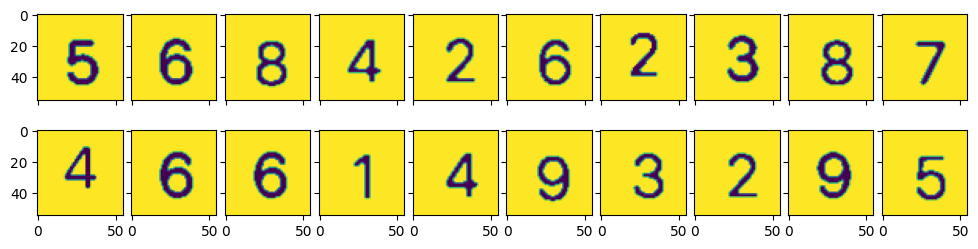

In [ ]:
df = pd.read_csv("dataset_train.csv")
print(df.shape)

fig, ax = plt.subplots(2,10, figsize=(12, 3), sharex=True, sharey=True)
img_idx = np.random.choice(df.shape[0], 2*10)
for i, ax in enumerate(ax.flatten()):
    img = Image.fromarray(df.iloc[img_idx[i], :-1].values.reshape(55,-1).astype('uint8'))
    ax.imshow(img) # or ax.imshow(img, cmap='gray_r')

plt.subplots_adjust(hspace=0, wspace=0.1)

Based on the above provided code (and the additional code snippet `print(df.shape)` we can conclude that the dataset has 1539 images of dimensions 55x55 (which equals to 3025, as the second element of the shape tells us). The reason why when printing shape the second element is 3026 and not 3025 is because the last column is the true label.

After running the code snippet several times, we noticed almost all of the images are normal and show only one digit with a few exceptions of fully purple images (which are actually blank). We will treat them as noise. What makes them different from the normal images is that all of their pixels are identical in colour, hence we will try to identify them by that characteristic.

In [ ]:
pixels = df.iloc[:, :-1]

exceptions = (pixels.nunique(axis=1) == 1)

print(f"Blank images found: {exceptions.sum()}")

blank_indices = df[exceptions].index


Blank images found: 24


In our entire dataset there are 24 blank images which we will remove.

In [ ]:
df_cleaned = df[~exceptions].reset_index(drop=True)
print(df_cleaned.shape)

(1506, 3026)


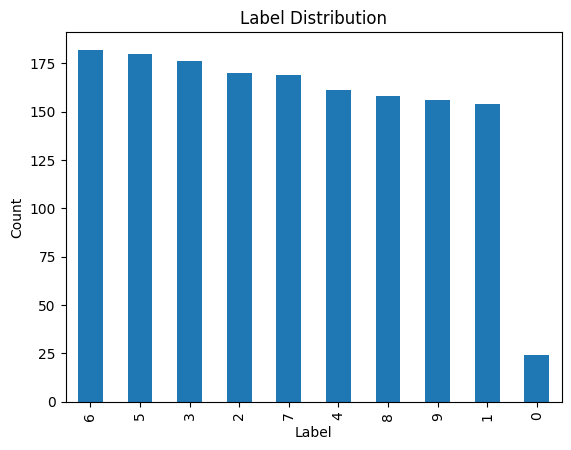

In [ ]:
df.iloc[:, -1].value_counts().plot(kind='bar')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

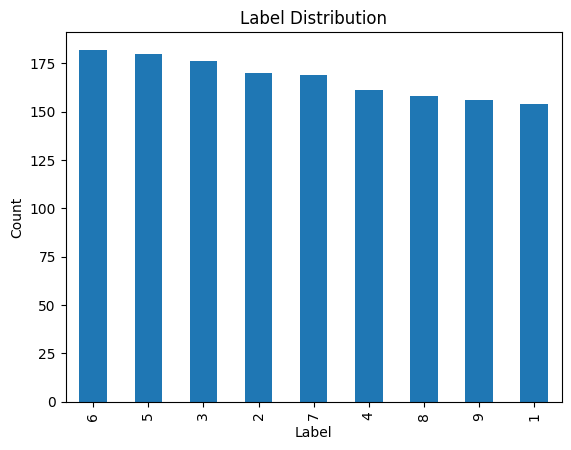

In [ ]:
df_cleaned.iloc[:, -1].value_counts().plot(kind='bar')
plt.title("Label Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

When running the code snippet that visualizes the numbers, we didn't see any zeros, however when looking at the distribution of labels in the original dataset there were 24 '0' labels. Then when we ran it again with the cleaned dataset there were no 0 labels. This means there is no need for imputing or removing any data.

Furthermore, by plotting the count of every digit we conclude that there is approximately the same number of each category in the dataset. This way we checked the sample size of classes.

In [ ]:
df_cleaned.head()

,0,1,2,3,4,5,6,7,8,9,...,3016,3017,3018,3019,3020,3021,3022,3023,3024,label
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,1
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,1
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,1
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,1
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,1


As the values of pixels go up to 255 we can do normalization to make the values in the range from 0 to 1. Before that we will separate the features and target variable.

In [ ]:
y_train = df_cleaned["label"]
X_train = df_cleaned.drop(["label"], axis=1)
print(X_train, y_train)

        0    1    2    3    4    5    6    7    8    9  ...  3015  3016  3017  \
0     255  255  255  255  255  255  255  255  255  255  ...   255   255   255   
1     255  255  255  255  255  255  255  255  255  255  ...   255   255   255   
2     255  255  255  255  255  255  255  255  255  255  ...   255   255   255   
3     255  255  255  255  255  255  255  255  255  255  ...   255   255   255   
4     255  255  255  255  255  255  255  255  255  255  ...   255   255   255   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
1501  255  255  255  255  255  255  255  255  255  255  ...   255   255   255   
1502  255  255  255  255  255  255  255  255  255  255  ...   255   255   255   
1503  255  255  255  255  255  255  255  255  255  255  ...   255   255   255   
1504  255  255  255  255  255  255  255  255  255  255  ...   255   255   255   
1505  255  255  255  255  255  255  255  255  255  255  ...   255   255   255   

      3018  3019  3020  302

In [ ]:
X_train_norm = X_train/255

In [ ]:
print(X_train_norm.shape)

(1506, 3025)


In [ ]:
print(X_train_norm)

        0    1    2    3    4    5    6    7    8    9  ...  3015  3016  3017  \
0     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   1.0   1.0   1.0   
1     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   1.0   1.0   1.0   
2     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   1.0   1.0   1.0   
3     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   1.0   1.0   1.0   
4     1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   1.0   1.0   1.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   ...   
1501  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   1.0   1.0   1.0   
1502  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   1.0   1.0   1.0   
1503  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   1.0   1.0   1.0   
1504  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   1.0   1.0   1.0   
1505  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...   1.0   1.0   1.0   

      3018  3019  3020  302

By printing out X_train_norm we have now confirmed that the values 255 now correspond to 1, the rest of the values are in range 0-255 and that the original shape of the dataset remained the same.

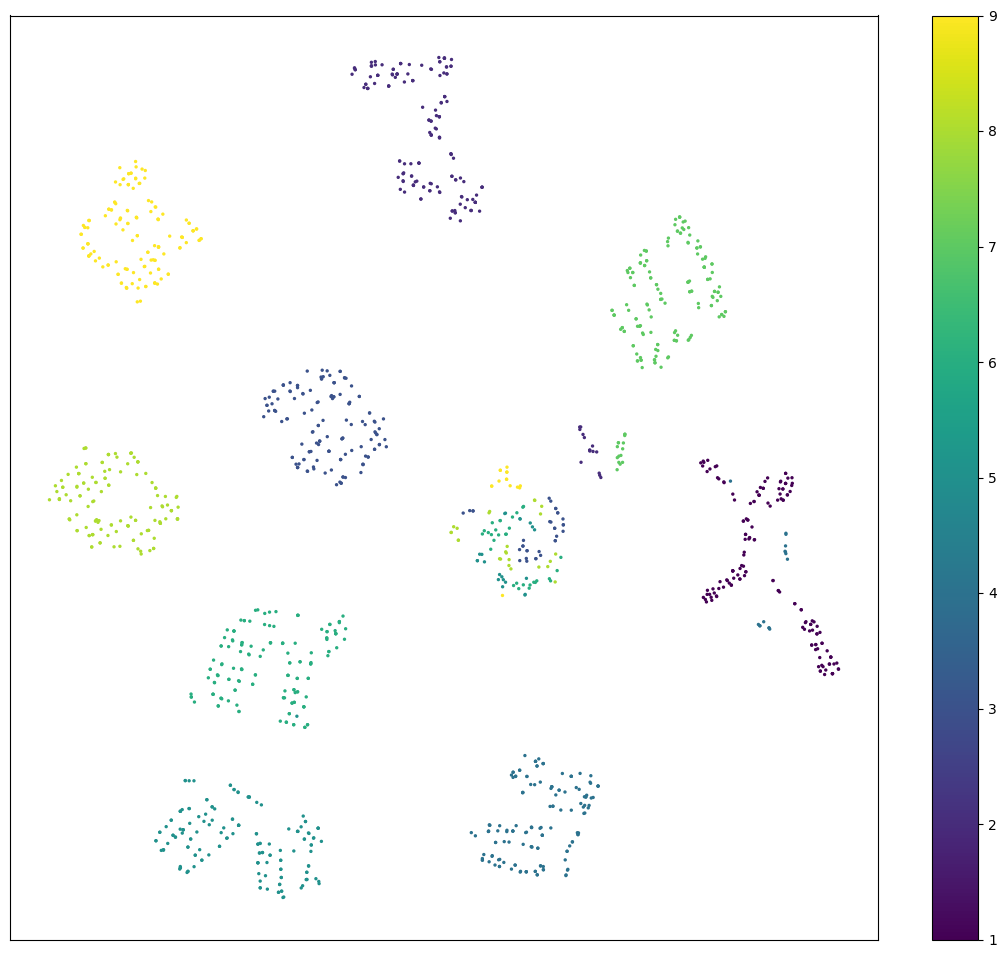

In [ ]:
tsne = TSNE()
tsne_res = tsne.fit_transform(X_train_norm)
plt.figure(figsize=(14, 12))
plt.scatter(tsne_res[:,0], tsne_res[:,1], c=y_train, s=2)
plt.xticks([])
plt.yticks([])
plt.colorbar()

We also decided to do t-SNE to see how if similar images (with the same label) are close to each other, which confirmed our theory.

#Simple ML models

##k-Nearest Neighbor

Based on the insight we gained through t-SNE we decided to try out kNN as the first simple ML model.

But beforehand, as we were only provided with the train dataset, we will treat as if it was the full one and perform a train-test split so in the end we could evaluate the models.

In [ ]:
X_newtrain, X_test, y_newtrain, y_test = train_test_split(
    X_train_norm, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

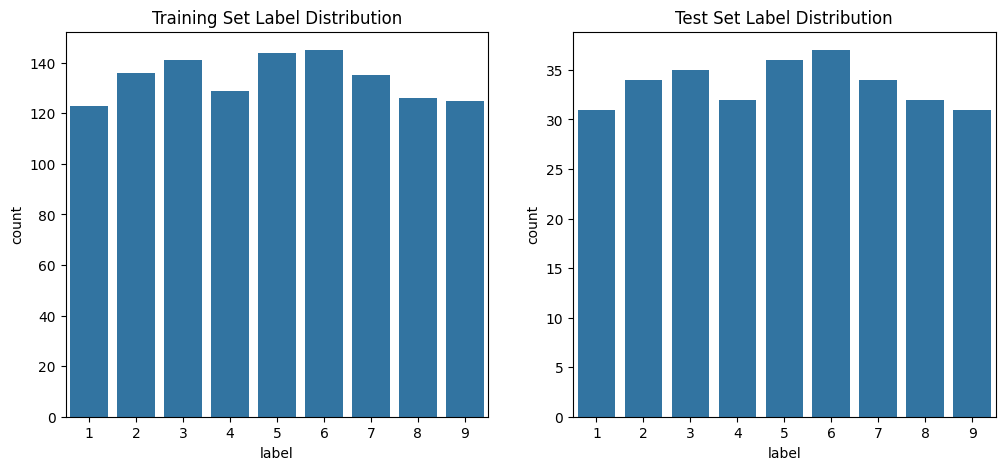

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.countplot(x=y_newtrain)
plt.title('Training Set Label Distribution')

plt.subplot(1, 2, 2)
sns.countplot(x=y_test)
plt.title('Test Set Label Distribution')

plt.show()

By plotting the distributions of the train and test dataset we can see that all classes/labels are distributed similarly to the dataset prior to the train_test_split.

The performance of a k-Nearest Neighbour model depends a lot on the k hyperparameter. The general rule of thumb is that a value of k around 5 performs very well, but we want to confirm which is truly the best by testing the model with values of k from 1 to 11.

In [ ]:
test_scores = []
train_scores = []
K = []
for k in range(1, 12):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_newtrain, y_newtrain)
    K.append(k)
    test_scores.append(knn.score(X_test, y_test))
    train_scores.append(knn.score(X_newtrain, y_newtrain))
    print('K=', K[k-1], ' test_score=', test_scores[k-1], '  train_test=', train_scores[k-1])

m = max(test_scores)
i = test_scores.index(m)
print('max accuracy ', m, '  train score: ', train_scores[i], '   for K=', K[i])

K= 1  test_score= 0.9966887417218543   train_test= 1.0
K= 2  test_score= 1.0   train_test= 0.9958471760797342
K= 3  test_score= 1.0   train_test= 0.9966777408637874
K= 4  test_score= 0.9966887417218543   train_test= 0.9950166112956811
K= 5  test_score= 0.9966887417218543   train_test= 0.9958471760797342
K= 6  test_score= 0.9933774834437086   train_test= 0.9933554817275747
K= 7  test_score= 0.9933774834437086   train_test= 0.9925249169435216
K= 8  test_score= 0.9933774834437086   train_test= 0.9900332225913622
K= 9  test_score= 0.9933774834437086   train_test= 0.9858803986710963
K= 10  test_score= 0.9900662251655629   train_test= 0.9867109634551495
K= 11  test_score= 0.9966887417218543   train_test= 0.9883720930232558
max accuracy  1.0   train score:  0.9958471760797342    for K= 2


Overall the model performed extremely well for every value, but the best result was with k=2.

In [ ]:
param = {'n_neighbors': list(range(1, 50))}

gs = GridSearchCV(KNeighborsClassifier(), param, cv=4)
result = gs.fit(X_newtrain, y_newtrain)

print(result.best_score_)
print(result.best_estimator_)
print(gs.score(X_test, y_test))

0.9908637873754153
KNeighborsClassifier(n_neighbors=3)
1.0


However when we used GridSearch we got the result that the model performs best for a value of k=3. As a lower value of k might lead to overfitting, we decided to opt for 3 instead of 2 (and because GridSearch is more reliable than simply looping).

In [ ]:
final_knn = KNeighborsClassifier(n_neighbors=3)
final_knn.fit(X_newtrain, y_newtrain)

test_accuracy = final_knn.score(X_test, y_test)
print(f"Final test accuracy where k = 3: {test_accuracy:.4f}")

Final test accuracy where k = 3: 1.0000


A lower k is more sensitive to noise, but as there is very small variance which we concluded by looking at the visual representation of the digits (none of them are hand-written and are almost in the same position in all examples), we believe it won't be a problem on the test dataset. However, if we were working with the MNIST dataset we would have chosen a much higher k, anywhere between 3 and ~38 (based on the square root of the number of features rule)

##SVM

In [ ]:
svm_model = SVC(kernel='rbf', C=1.0)
svm_model.fit(X_newtrain, y_newtrain)

test_accuracy = svm_model.score(X_test, y_test)
print(f"SVM Test Accuracy: {test_accuracy:.4f}")

SVM Test Accuracy: 1.0000


In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid = GridSearchCV(SVC(), param_grid, cv=4)
grid.fit(X_newtrain, y_newtrain)

print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

print("Test set accuracy:", grid.score(X_test, y_test))

Best parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy: 0.9975083056478404
Test set accuracy: 1.0


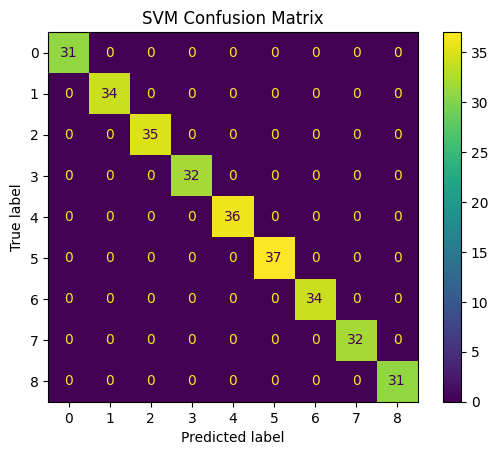

In [ ]:
y_pred_svm = svm_model.predict(X_test)
cm_svm = confusion_matrix(y_test, y_pred_svm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp.plot()
plt.title('SVM Confusion Matrix')
plt.show()

#MLP

The third model we will be building is a multi layer perceptron. The last layer has to have 9 neurons for each of the digits (without 0).

In [ ]:
X_newtrain.shape

(1204, 3025)

In [ ]:
y_newtrain = to_categorical(y_newtrain - 1, num_classes=9)

model_MLP = tf.keras.Sequential([
    tf.keras.Input(shape=(3025,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])

In [ ]:
model_MLP.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_MLP.fit(X_newtrain, y_newtrain, epochs=10,
          batch_size=32,
          validation_split=0.2)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.1692 - loss: 2.3189 - val_accuracy: 0.1328 - val_loss: 2.1490
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3547 - loss: 1.8038 - val_accuracy: 0.5768 - val_loss: 1.3251
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6599 - loss: 1.1726 - val_accuracy: 0.7967 - val_loss: 0.9007
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7499 - loss: 0.8429 - val_accuracy: 0.8008 - val_loss: 0.7043
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8319 - loss: 0.6634 - val_accuracy: 0.8838 - val_loss: 0.4933
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8961 - loss: 0.4884 - val_accuracy: 0.9253 - val_loss: 0.3975
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9057 - loss: 0.4098 - val_accuracy: 0.9419 - val_loss: 0.3193
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9634 - loss: 0.2457 - val_accuracy: 0.9585 - val_loss

The MLP, although it has only 2 hidden layers performs surprisingly well with an accuract of 0.948 and a validation accuracy of 0.975.

#CNN

In [ ]:
model_CNN = tf.keras.Sequential([
    tf.keras.layers.Reshape((55, 55, 1), input_shape=(3025,)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(9, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
model_CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_CNN.fit(X_newtrain, y_newtrain, epochs=10,
          batch_size=32,
          validation_split=0.2)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 153ms/step - accuracy: 0.3067 - loss: 2.0813 - val_accuracy: 0.7220 - val_loss: 0.8329
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.8829 - loss: 0.4889 - val_accuracy: 0.9710 - val_loss: 0.1173
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.9749 - loss: 0.0994 - val_accuracy: 0.9793 - val_loss: 0.0586
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.9871 - loss: 0.0411 - val_accuracy: 0.9917 - val_loss: 0.0276
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.9959 - val_loss: 0.0222
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - accuracy: 1.0000 - loss: 0.0041 - val_accuracy: 0.9959 - val_loss: 0.0243
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 0.9959 - val_loss: 0.0258
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.

Resources: https://www.geeksforgeeks.org/multi-layer-perceptron-learning-in-tensorflow/
https://www.geeksforgeeks.org/convolutional-neural-network-cnn-in-tensorflow/